<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Clustering</h1></center>

## Introduction
To build our recommendation engine, the first crucial step is to group users into clusters. This process begins by merging all relevant data into a comprehensive dataset (`all_orders`). 

Next, we generate features representing aisle preferences before applying **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset (the number of product features). This step improves performance by simplifying the data while preserving essential information.

Finally, we apply **K-Means clustering** to identify the optimal number of user segments and assign each user to their respective cluster based on their aisle preferences, forming the foundation for personalized recommendations.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
order_products_prior = pd.read_csv('Data/order_products__prior.csv')
order_products_train = pd.read_csv('Data/order_products__train.csv')
departments = pd.read_csv('Data/departments.csv')
products = pd.read_csv('Data/products.csv')
aisles = pd.read_csv('Data/aisles.csv')
orders = pd.read_csv('Data/orders.csv')

In [3]:
all_orders = pd.concat([order_products_prior,order_products_train])
all_orders = all_orders.merge(orders[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles, on = 'aisle_id', how='inner')
all_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,Natural Sweetener,17,13,pantry,baking ingredients


In [4]:
all_orders.shape

(33819106, 10)

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Feature Engineering "Aisle Share"</h1>

Before running our kmeans clustering algorithm, we wanted to develop a feature that would capture the relationship between the products purchased and aisles per user. We did this by counting the total number of products by aisle over total products purchased. we want to determine how much of a user's total purchases come from each aisle. This feature, called "aisle share", will represent the proportion of a user’s total product purchases that come from a specific aisle. It will be used later as input for clustering to group users based on their purchasing habits.

This feature represents a user's purchase behavior (which aisles they tend to buy from), and serves as a profile for each user.

In [5]:
# Count how many products each user bought from each aisle
cnt_per_aisle = all_orders[['user_id','aisle','product_name']].groupby(['user_id', 'aisle']).count().reset_index() 
cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name':'product_cnt_per_aisle'})
cnt_per_aisle

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1
...,...,...,...
5919835,206209,soft drinks,11
5919836,206209,soy lactosefree,10
5919837,206209,spices seasonings,1
5919838,206209,trash bags liners,1


In [6]:
# Calculate the total number of products bought by each user across all aisles
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,aisle,product_cnt_per_aisle
user_id,,
1,candy chocolatecerealcreamfresh fruitsmilknuts...,70
2,asian foodsbaking ingredientsbreadbreakfast ba...,226
3,crackersfresh fruitsfresh vegetablesfrozen bre...,88
4,breadchips pretzelsdish detergentsfresh dips t...,18
5,air fresheners candlesasian foodscanned jarred...,46
...,...,...
206205,baby accessoriesbreadcondimentscreamfresh dips...,51
206206,asian foodsbaking ingredientsbaking supplies d...,285
206207,baby food formulabreadcanned jarred vegetables...,223


We ensure that for each user, we know how many products they bought from each aisle `(cnt_per_aisle)` and the total number of products they bought across all aisles `(ttl_per_user)`.

In [7]:
# Calculate total product count per aisle
cnt_per_aisle = all_orders.groupby(['user_id', 'aisle']).size().reset_index(name='product_cnt_per_aisle')

# Calculate total product count per user
ttl_per_user = cnt_per_aisle.groupby('user_id')['product_cnt_per_aisle'].sum().reset_index(name='ttl_product_cnt_per_user')

In [8]:
# We merge the aisle-wise product counts (cnt_per_aisle) with the total product counts for each user (ttl_per_user)
aisle_share_per_user = cnt_per_aisle.merge(ttl_per_user, how="left", on="user_id")

# We calculate the aisle share, which is the proportion of the user's purchases that come from a particular aisle
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle"] / aisle_share_per_user["ttl_product_cnt_per_user"]

# Drop unnecessary columns
aisle_share_per_user.drop(["product_cnt_per_aisle", "ttl_product_cnt_per_user"], axis=1, inplace=True)
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


This new feature, `aisle share`, summarizes each user’s preference for certain aisles relative to their total shopping behavior. It helps in clustering users based on their aisle preferences, so It gives insight into each user's preference for different aisles which is a key step in building personalized recommendation systems. By grouping users who have similar shopping patterns, the system can better understand user behaviors and make more accurate recommendations.

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Preparing our dataset for dimensionality reduction</h1>

Before performing our principal component analysis we need to adjust our dataframe using pivot to transform our aisle per share into columns (features). 

# Create the User-Aisle Matrix

We pivot the `aisle_share_per_user` DataFrame to transform the data into a format where each column corresponds to an aisle, and each row corresponds to a user.
Explanation:
The `pivot()` function rearranges the data such that the aisles become the columns, the users become the rows (index), and the values in the table are the `aisle_share` (proportion of purchases from that aisle).
Now, each row represents a user and contains their `aisle share` for every aisle they bought products from.

Most clustering algorithms (like K-Means) and dimensionality reduction techniques (like PCA) require the input data to be in a tabular format, where each row is an observation (user) and each column is a feature (aisle).and also by povting we convert the aisle_share feature into a format where each aisle becomes a separate feature. This allows the algorithm to analyze the relationship between users and aisles directly

In [9]:
#Setting aisles as columns by user id using pivot. 
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share").fillna(0)
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.028571
2,0.000000,0.013274,0.000000,0.0,0.000000,0.0,0.008850,0.000000,0.0,0.0,...,0.013274,0.004425,0.004425,0.000000,0.000000,0.000000,0.0,0.008850,0.0,0.185841
3,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.000000,0.000000,0.0,0.022727,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.0,0.055556,0.0,0.000000
5,0.021739,0.086957,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.000000,0.000000,0.019608,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.176471
206206,0.000000,0.014035,0.000000,0.0,0.000000,0.0,0.014035,0.003509,0.0,0.0,...,0.003509,0.000000,0.000000,0.000000,0.000000,0.003509,0.0,0.003509,0.0,0.000000
206207,0.000000,0.000000,0.000000,0.0,0.004484,0.0,0.000000,0.000000,0.0,0.0,...,0.013453,0.017937,0.000000,0.008969,0.004484,0.000000,0.0,0.049327,0.0,0.067265



Finally have a **user-aisle matrix** where each user’s behavior (`aisle share`) is now captured in a single row. This will make it easier to perform dimensionality reduction using PCA.


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Dimensionality reduction using PCA </h1>

The goal is to reduce the complexity of the dataset and size (with 134 columns/features) while maintaining as much of the variance in the data as possible and alsocan help filter out irrelevant features and noise that may not contribute to distinguishing between user behaviors

but first we need to scale the data so when we apply PCA to the scaled data, we're ensuring that PCA is capturing the variance in the data more effectively.

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Scaling Data </h1>

In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(aisle_share_pivot)

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Finding the optimal number of dimensions</h1>

we need to decide how many principal components to keep. To do this so We plot the elbow curve to visually inspect how the explained variance changes with the number of components. This curve helps us understand the relationship between the number of principal components (dimensions) and the cumulative explained variance.

Threshold: A typical approach is to retain components that together explain 80% of the variance in the data. This ensures that most of the important information is preserved while reducing dimensionality.

By applying PCA and reducing the number of dimensions from 134 to 33, we significantly reduce the complexity of the dataset. This helps:

Improve the performance of downstream algorithms, such as k-means clustering.
Remove noise or less important features while preserving the key variance in the dataset.
Make the data more manageable and interpretable, allowing us to focus on the most meaningful patterns for clustering and recommendation tasks.

Using the elbow curve and a threshold of 80% explained variance, we find the optimal nubmer of dimensions to be 99

In [11]:
pca = PCA()
pca.fit(scaled_data)

# Cumulative variance explained helps us decide how many components to keep by showing how much variance is preserved as we add more components
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.80
d = np.argmax(cumsum >= threshold) + 1
print(f"Number of components explaining {threshold * 100}% variance: {d}")

Number of components explaining 80.0% variance: 99


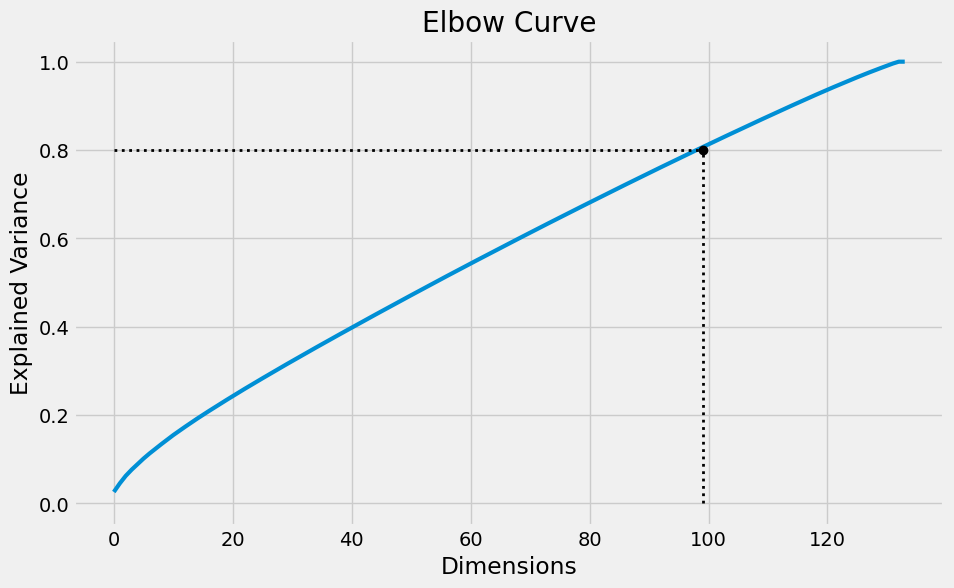

In [12]:
# Display Elbow Curve
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow Curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:", linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Reducing our dataframe using 99 components </h1>

In [13]:
# PCA with the optimal number of components
pca = PCA(n_components=d)
principalComponents = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA components
PCA_components = pd.DataFrame(principalComponents)
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,-1.928746,-3.337820,0.247710,0.756032,-2.208211,-1.174143,-0.845441,-1.251188,1.903827,-0.354800,...,2.096834,1.997176,0.153462,-0.498008,0.043185,-0.628138,1.859912,0.525244,0.693360,-0.110518
1,-0.358639,-2.000693,-0.559800,-1.139831,0.789701,-0.785304,-0.768200,-0.261209,0.147106,-0.334917,...,0.401311,0.042413,0.579076,-0.265189,-0.458123,1.161385,0.249569,0.091698,0.277007,-0.168194
2,0.796118,-1.422625,0.632894,-1.284349,0.732098,0.087881,-0.215746,1.032626,0.279313,-0.355625,...,1.355473,1.138615,-0.791719,0.547813,-1.263977,0.329019,0.836063,-1.184134,-0.690937,0.231698
3,-2.003292,-0.577940,-0.577431,2.451954,3.028633,-0.239182,-0.616290,0.381651,0.469191,1.338900,...,0.885052,-0.060768,1.602112,1.668285,1.138072,-1.245812,-2.767824,1.343263,1.475510,-1.594202
4,1.643346,0.716632,1.246590,-0.136636,0.349787,-0.322172,0.608895,-0.133531,-0.937232,0.008459,...,-1.356001,0.310738,-0.006372,0.844034,0.383654,0.385218,1.605125,0.551592,0.081033,0.164750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.684424,-0.906513,0.285939,-1.783025,1.484663,1.589165,0.842393,-0.191702,0.105604,0.214954,...,-0.125627,-1.946121,1.547438,1.699972,-0.268375,0.342444,0.202144,0.559539,-1.400830,-0.111224
206205,-0.968908,-0.191023,-0.319107,-0.030080,0.187408,-1.279023,1.000906,-0.579561,-2.103118,0.537733,...,0.120258,0.097690,-0.045152,-0.323587,0.274074,0.871783,0.520530,-0.646414,0.107763,-1.196851
206206,1.090235,0.036046,-0.695472,-0.263667,-0.020044,-0.063039,-0.250568,0.401440,0.786590,-0.094273,...,-0.129763,-0.878581,-0.076580,-0.123245,-0.761334,0.385177,-0.252749,0.082553,-0.133988,0.399377
206207,1.064533,0.045993,-0.037079,-0.571071,0.030091,0.924935,1.137822,-0.434162,-0.100469,-0.682919,...,-0.278390,-0.244620,0.010434,-0.089944,0.152555,-0.624115,-0.795849,-0.198620,0.492453,-0.044171


In [14]:
# Save the PCA components to a CSV file (optional)
# PCA_components.to_csv('PCA_components.csv', index=False)

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Segmenting our users using K-Means</h1>

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Find optimal number of clusters using elbow method </h2>
Using 3 different methods we evaluate the optimal number of clusters to use for our segmentation. 

In [15]:
# Finding optimal number of clusters. 
sse = {}
labels = {}
for k in range(5,30):
    print(f"Fitting for k={k}...")
    kmeans = KMeans(n_clusters = k, random_state=42).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
    print(f"SSE for k={k}: {sse[k]}")

Fitting for k=5...
SSE for k=5: 20996343.3203391
Fitting for k=6...
SSE for k=6: 20896011.947326735
Fitting for k=7...
SSE for k=7: 20666519.224885263
Fitting for k=8...
SSE for k=8: 20564741.19458193
Fitting for k=9...
SSE for k=9: 20481231.08036703
Fitting for k=10...
SSE for k=10: 20321594.264285777
Fitting for k=11...
SSE for k=11: 20202686.05934292
Fitting for k=12...
SSE for k=12: 20110947.49362554
Fitting for k=13...
SSE for k=13: 19991077.898284197
Fitting for k=14...
SSE for k=14: 19880413.109576188
Fitting for k=15...
SSE for k=15: 19768527.78891635
Fitting for k=16...
SSE for k=16: 19538226.380661447
Fitting for k=17...
SSE for k=17: 19424226.577397037
Fitting for k=18...
SSE for k=18: 19325061.83754643
Fitting for k=19...
SSE for k=19: 19221031.742717557
Fitting for k=20...
SSE for k=20: 19107603.791776657
Fitting for k=21...
SSE for k=21: 19046389.086414475
Fitting for k=22...
SSE for k=22: 18956465.11896278
Fitting for k=23...
SSE for k=23: 18886018.93263071
Fitting for k

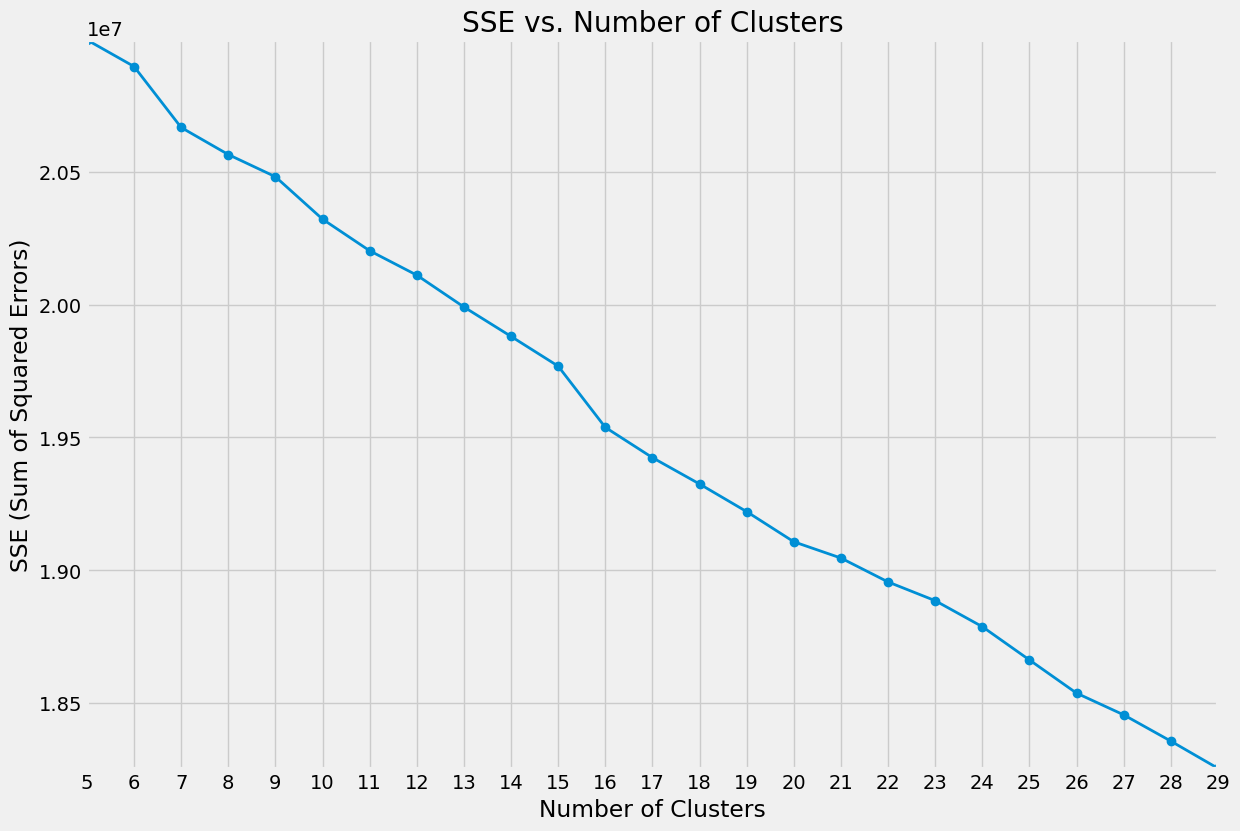

In [16]:
# Elbow Method
plt.figure(figsize=(13,9))
plt.plot(list(sse.keys()), list(sse.values()), "-o", linewidth=2)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.title("SSE vs. Number of Clusters")
plt.ylim(min(sse.values())-1000, max(sse.values())+1000)  # Adjust y-limits
plt.xlim(min(sse.keys()), max(sse.keys()))  # Adjust x-limits
plt.xticks(range(5, 30))  # Ensure this is the correct range
plt.grid(True)
plt.show()

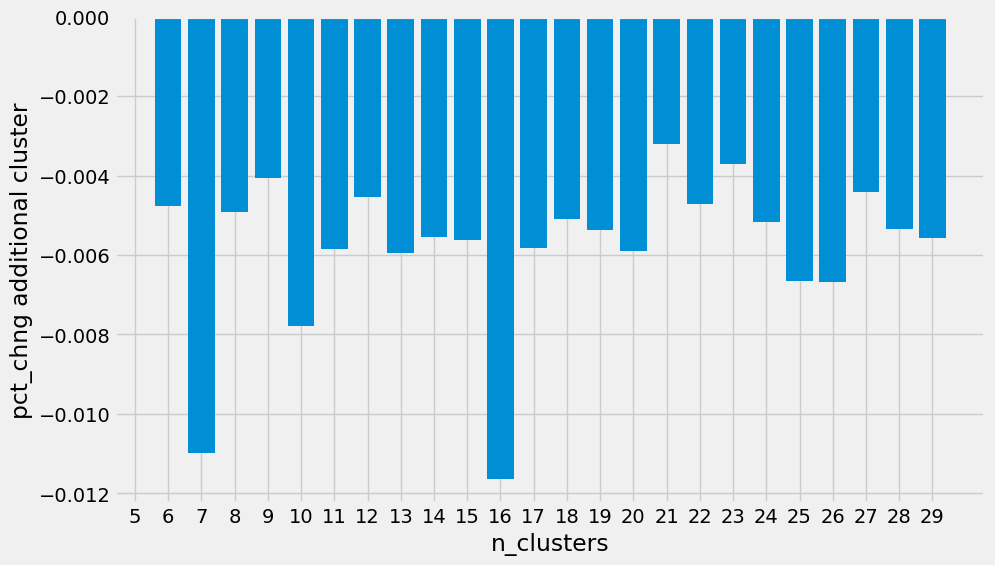

In [17]:
pct_change_clusters = pd.Series(sse.values()).pct_change()
plt.figure(figsize=(10,6))
plt.bar(sse.keys(), pct_change_clusters)
plt.xlabel("n_clusters")
plt.ylabel("pct_chng additional cluster")
plt.xticks(np.arange(5, 30))
plt.show()


In [25]:
# Setting k to 16
k = 16
cluster_labels = labels[k]

In [26]:
cluster_df = pd.DataFrame({'user_id': aisle_share_pivot.index, 'cluster': cluster_labels})
cluster_aisle_br = aisle_share_per_user.merge(cluster_df, on='user_id')
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,15
1,1,cereal,0.057143,15
2,1,cream,0.042857,15
3,1,fresh fruits,0.071429,15
4,1,milk,0.014286,15
...,...,...,...,...
5919835,206209,soft drinks,0.080292,10
5919836,206209,soy lactosefree,0.072993,10
5919837,206209,spices seasonings,0.007299,10
5919838,206209,trash bags liners,0.007299,10


In [2]:
# Add cluster labels to the main dataset
all_orders_cluster = all_orders.merge(cluster_df, on='user_id')
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,8
1,2,28985,2,1,202279,Michigan Organic Kale,83,4,produce,fresh vegetables,8
2,2,9327,3,0,202279,Garlic Powder,104,13,pantry,spices seasonings,8
3,2,45918,4,1,202279,Coconut Butter,19,13,pantry,oils vinegars,8
4,2,30035,5,0,202279,Natural Sweetener,17,13,pantry,baking ingredients,8
...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421063,14233,3,1,169679,Natural Artesian Water,115,7,beverages,water seltzer sparkling water,10
33819102,3421063,35548,4,1,169679,Twice Baked Potatoes,13,20,deli,prepared meals,10
33819103,3421070,35951,1,1,139822,Organic Unsweetened Almond Milk,91,16,dairy eggs,soy lactosefree,10
33819104,3421070,16953,2,1,139822,Creamy Peanut Butter,88,13,pantry,spreads,10


In [49]:
# all_orders_cluster.to_csv('all_orders_cluster.csv', index=False)


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Exploring the clusters </h1>


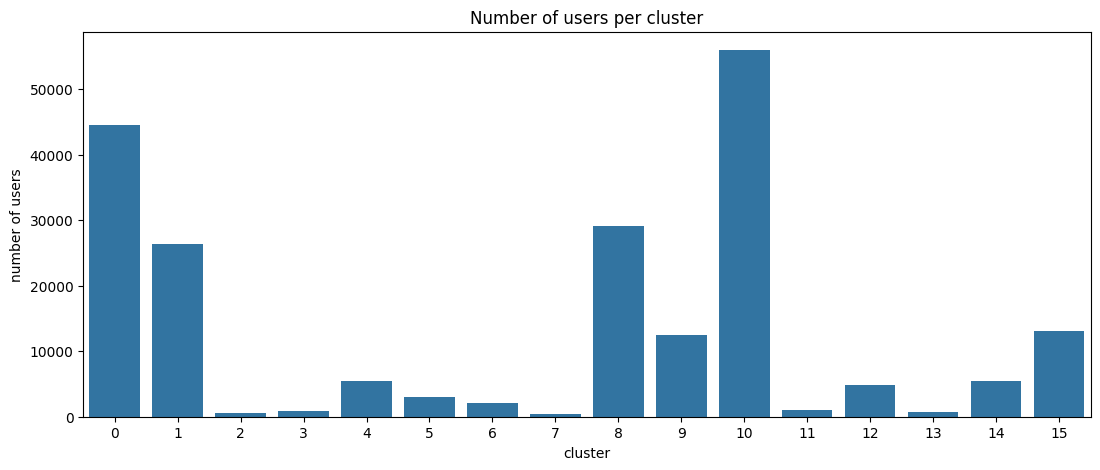

In [7]:
# checking the number of users per cluster
user_per_cluster = all_orders_cluster.groupby("cluster").nunique()["user_id"]
plt.figure(figsize=(13, 5))
sns.barplot(x=user_per_cluster.index, y=user_per_cluster.values)
plt.title("Number of users per cluster")
plt.xlabel("cluster")
plt.ylabel("number of users")
plt.show()

Looking at the above graph we can see, that `cluster 0`, `cluster 8` and `cluster 10` have the most users, where as `cluster 7` and `cluster 13` have the least. Although users is an inidcator, let's see how it looks in terms of number of orders

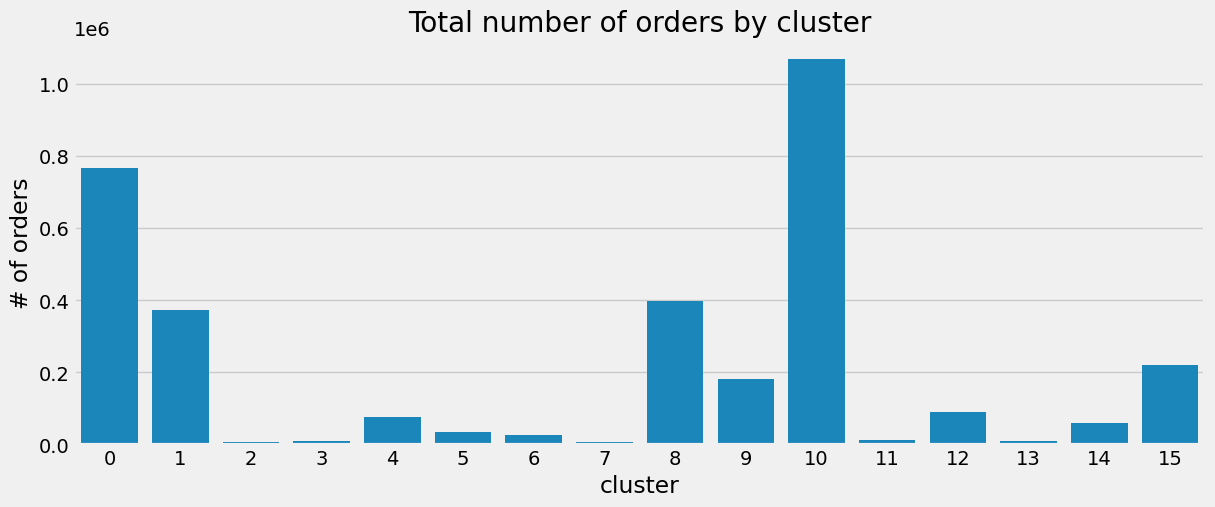

In [50]:
# Calculating the number of users per cluster
orders_per_cluster=all_orders_cluster.groupby("cluster")["order_id"].nunique()
plt.figure(figsize=(13,5))
sns.barplot(x=orders_per_cluster.index, y=orders_per_cluster.values)
plt.title("Total number of orders by cluster")
plt.ylabel("# of orders")
plt.show()

As expected, the distribution of the total number of orders per cluster looks similar as the total number of users per clusters as more useres usually also means more orders. Let's explore the ratios...

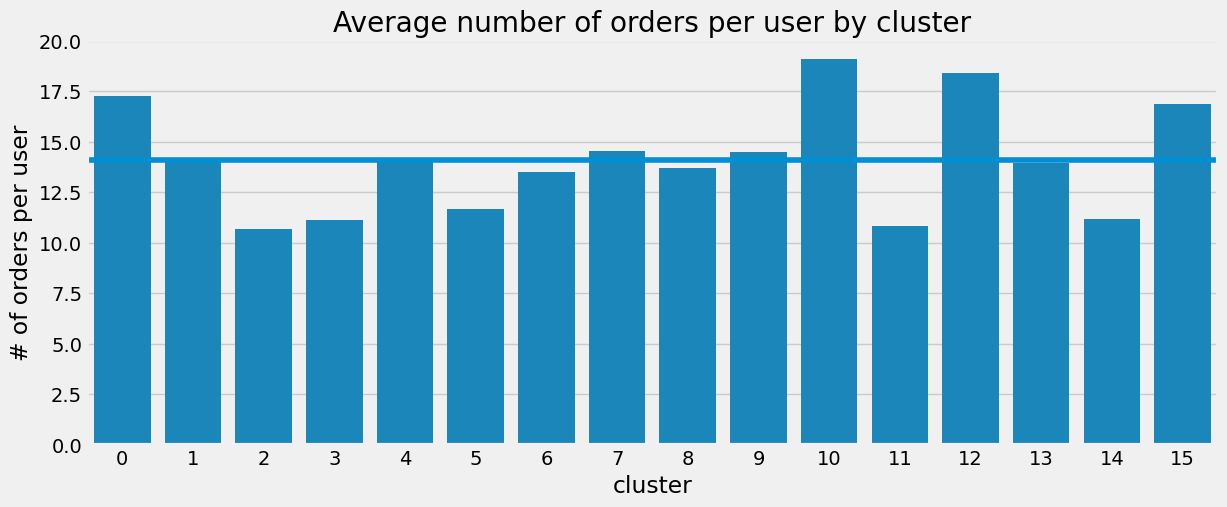

In [51]:
plt.figure(figsize=(13,5))
sns.barplot(x=orders_per_cluster.index, y=orders_per_cluster.values/user_per_cluster.values).axhline(np.mean(orders_per_cluster.values/user_per_cluster.values))
plt.title("Average number of orders per user by cluster")
plt.ylabel("# of orders per user")
plt.show()

When we look at the average number of orders per user we have a a bit a more even distribution. `cluster 0` , `cluster 10` , `cluster 12` and `cluster 15` users tend to order the most, where as `cluster 2` & `cluster 11` users have the loweser average number of orders.

Next, let's check if there is a significant difference in the average number of products bought per order...

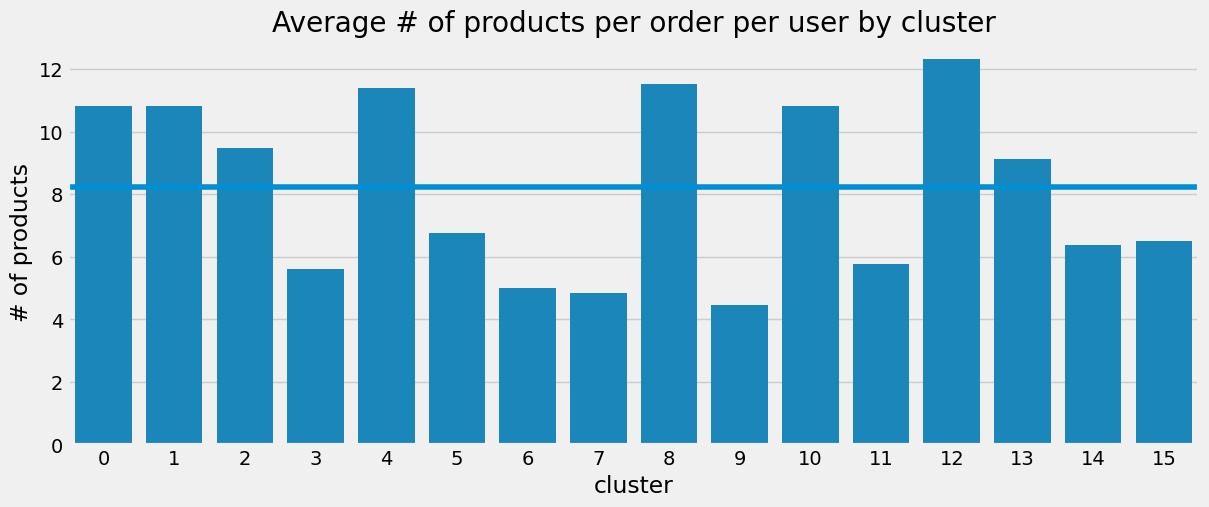

In [52]:
avg_num_prod_per_order_by_cluster = all_orders_cluster.groupby(["cluster","order_id"]).count()["product_id"].groupby("cluster").mean()
plt.figure(figsize=(13,5))
sns.barplot(x=avg_num_prod_per_order_by_cluster.index, y=avg_num_prod_per_order_by_cluster.values).axhline(np.mean(avg_num_prod_per_order_by_cluster))
plt.title("Average # of products per order per user by cluster")
plt.ylabel("# of products")
plt.show()

In [54]:
# Count the number of times each product is bought within each cluster
top_products_by_cluster = (all_orders_cluster.groupby(['cluster', 'product_name'])['product_id'].count().reset_index().sort_values(['cluster', 'product_id'], ascending=[True, False]))

# Group by 'cluster' and get the top 5 products in each cluster
top_products_by_cluster = top_products_by_cluster.groupby('cluster').head(5)
top_products_by_cluster

,cluster,product_name,product_id
2754,0,Banana,123109
21494,0,Organic Baby Spinach,103965
2586,0,Bag of Organic Bananas,101881
22867,0,Organic Hass Avocado,78868
24398,0,Organic Strawberries,77155
...,...,...,...
360419,15,Soda,20889
338994,15,Banana,16584
338865,15,Bag of Organic Bananas,14941
360773,15,Sparkling Water Grapefruit,12220


/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 1500x800 with 0 Axes>

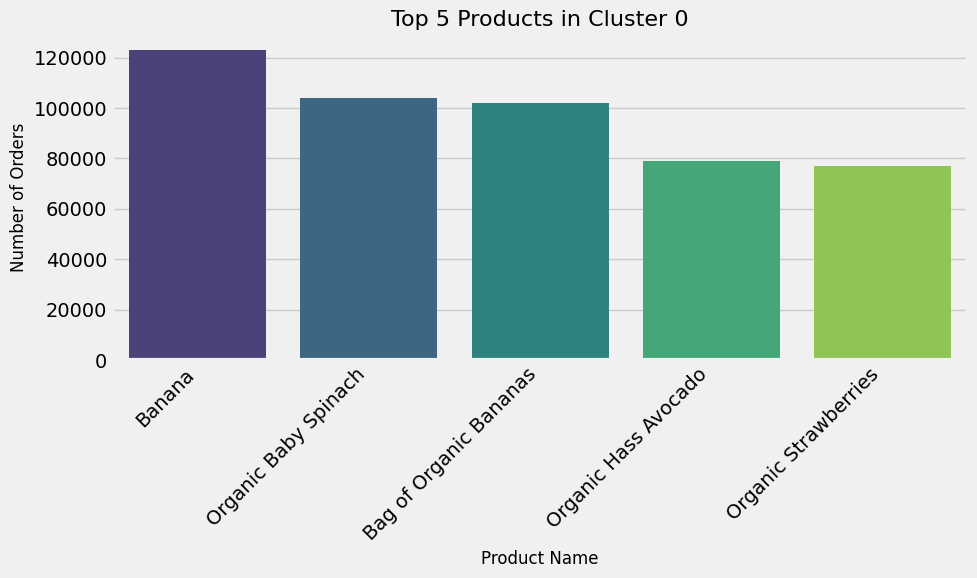

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


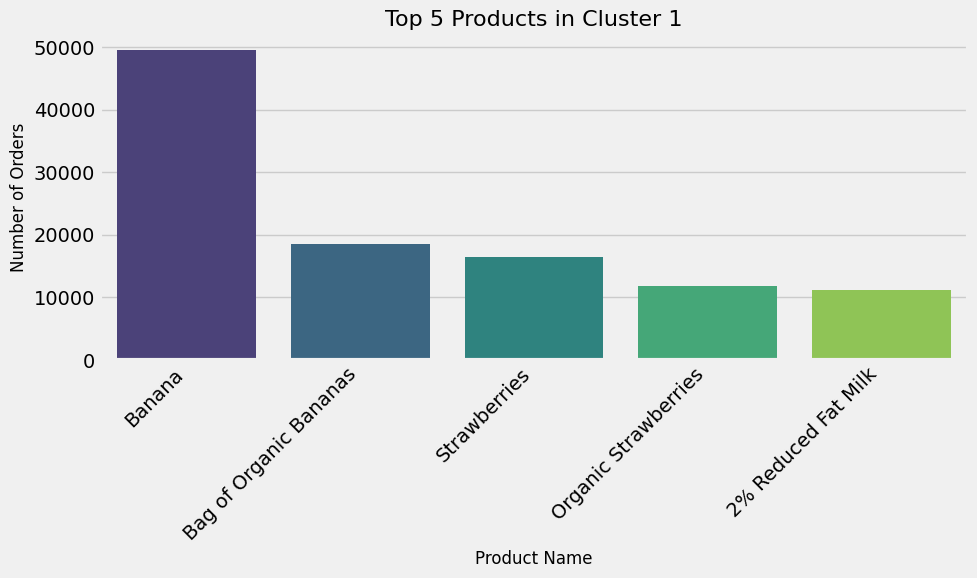

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


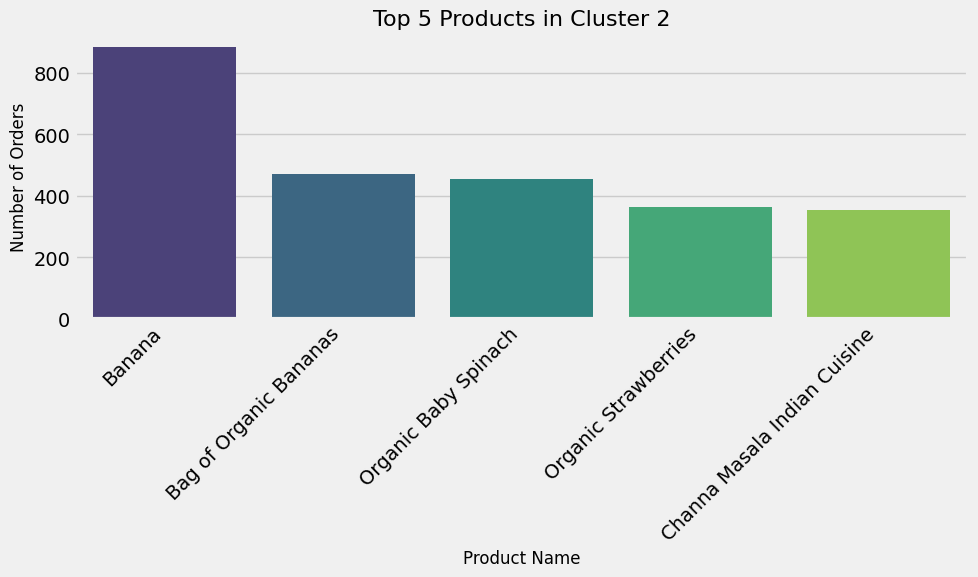

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


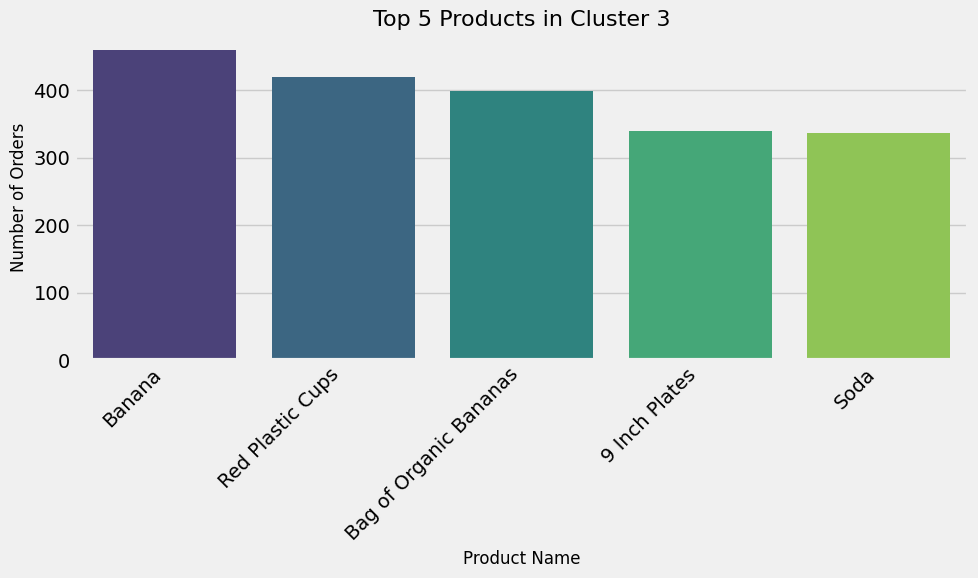

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


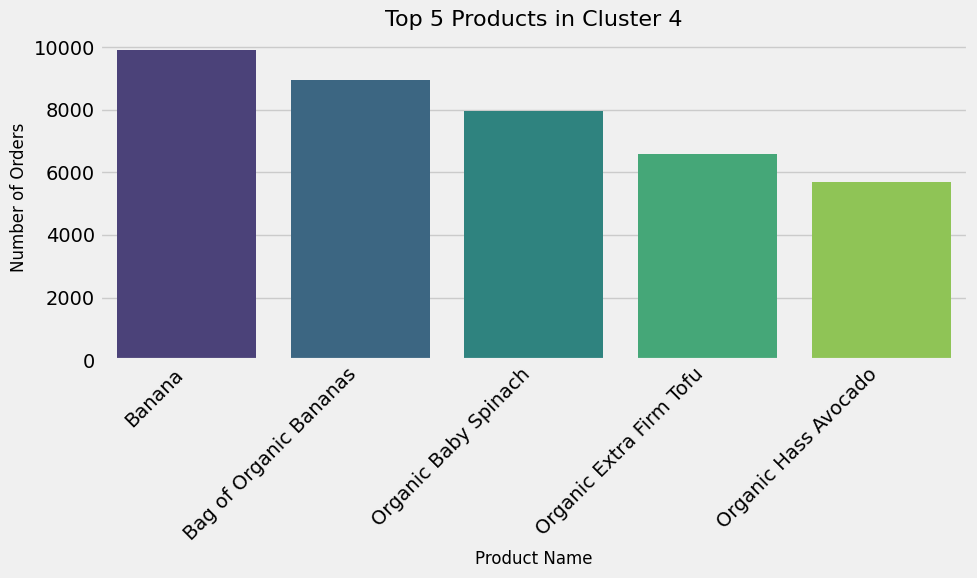

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


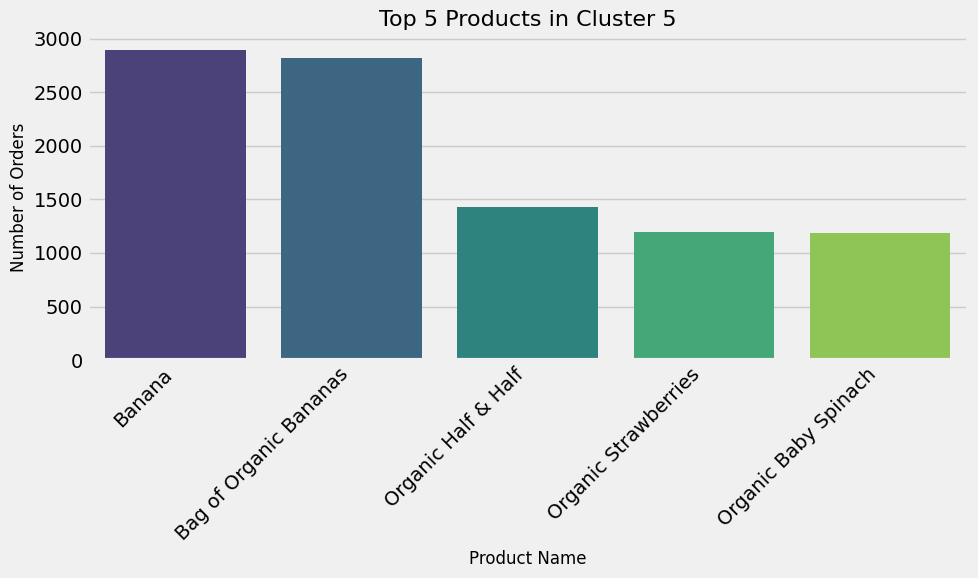

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


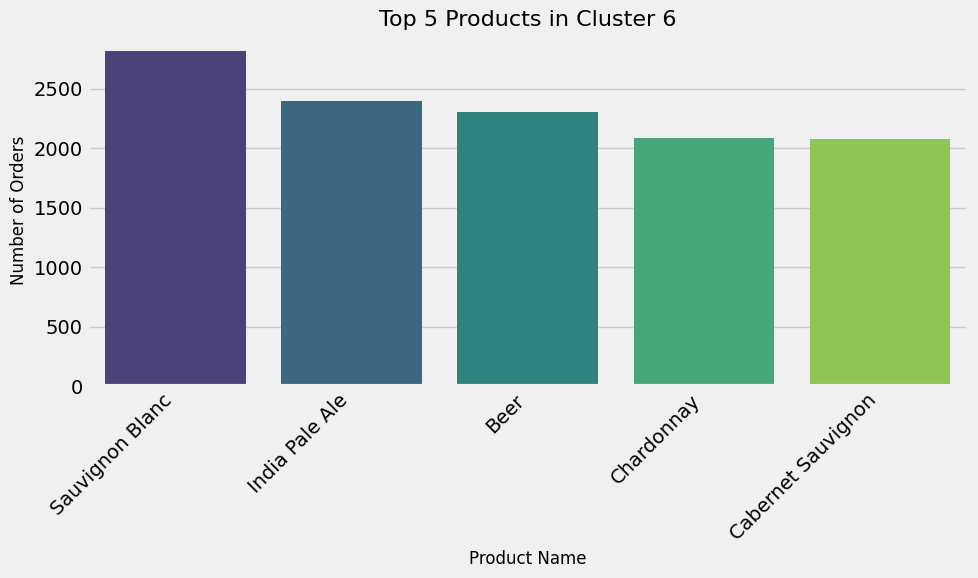

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


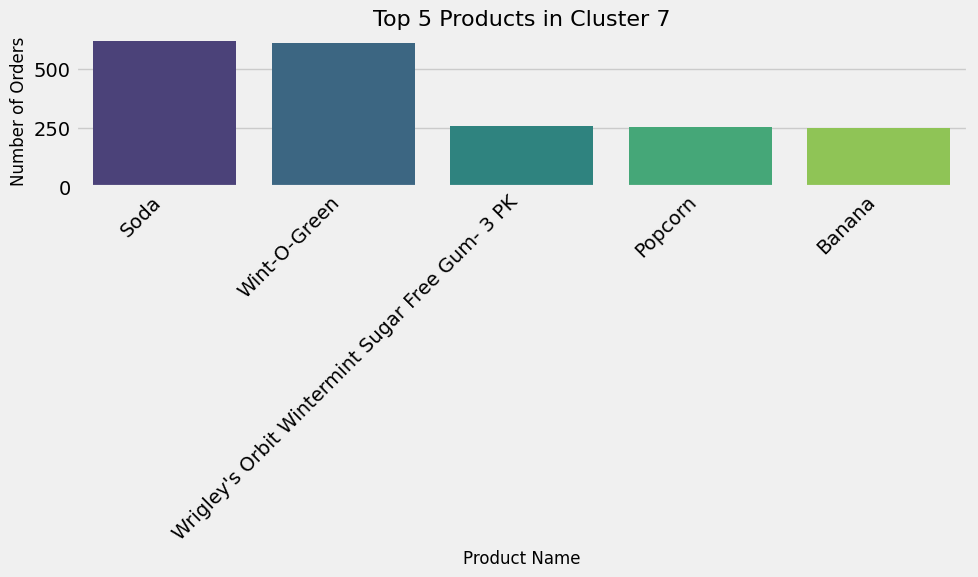

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


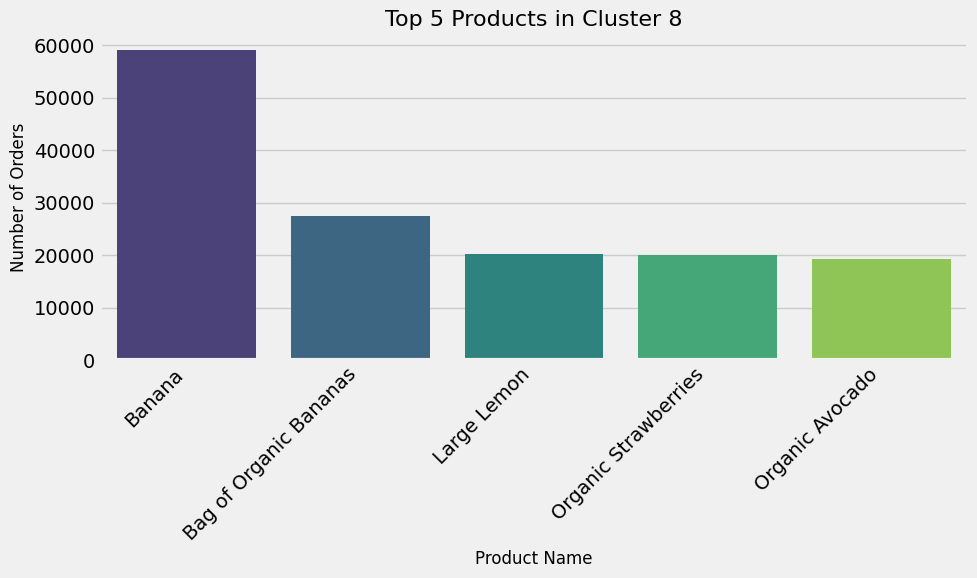

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


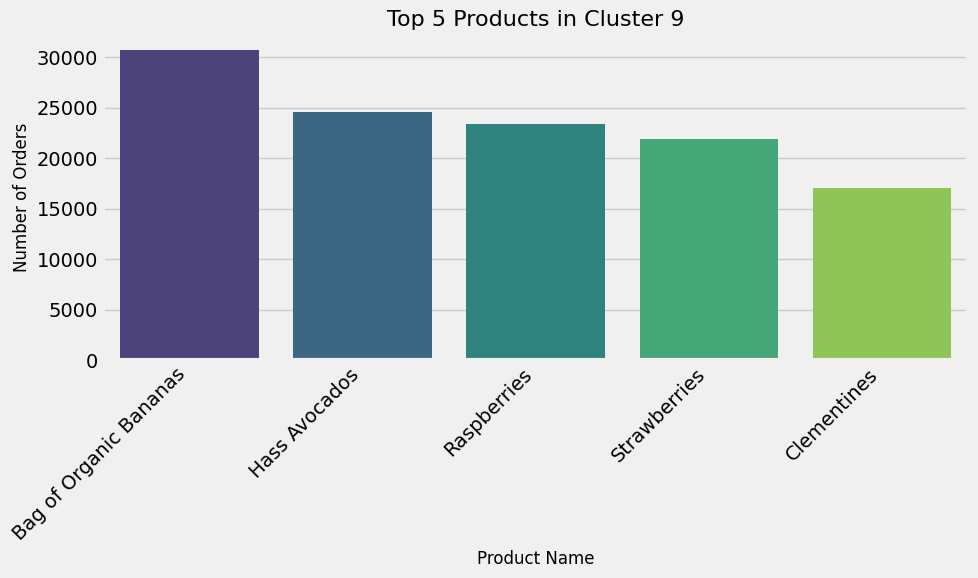

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


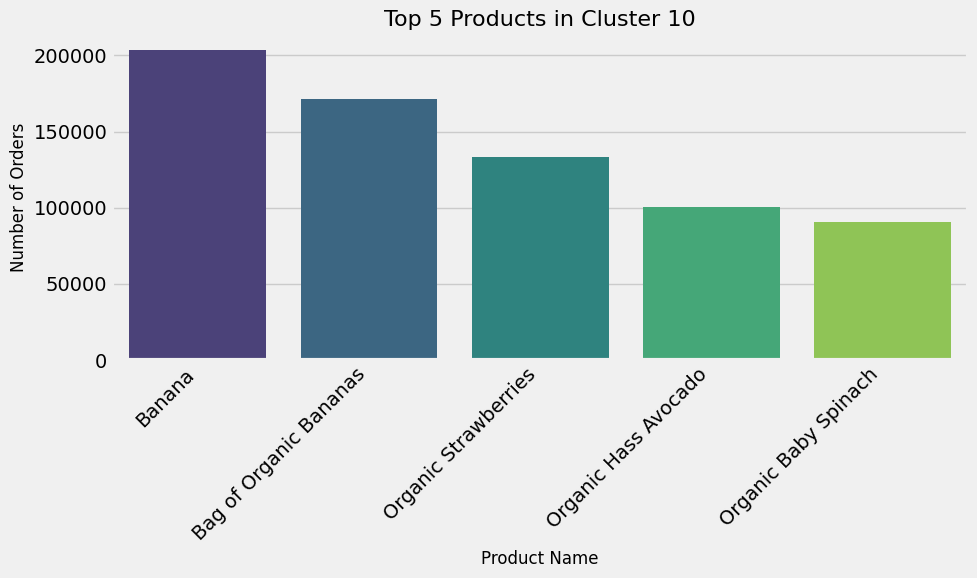

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


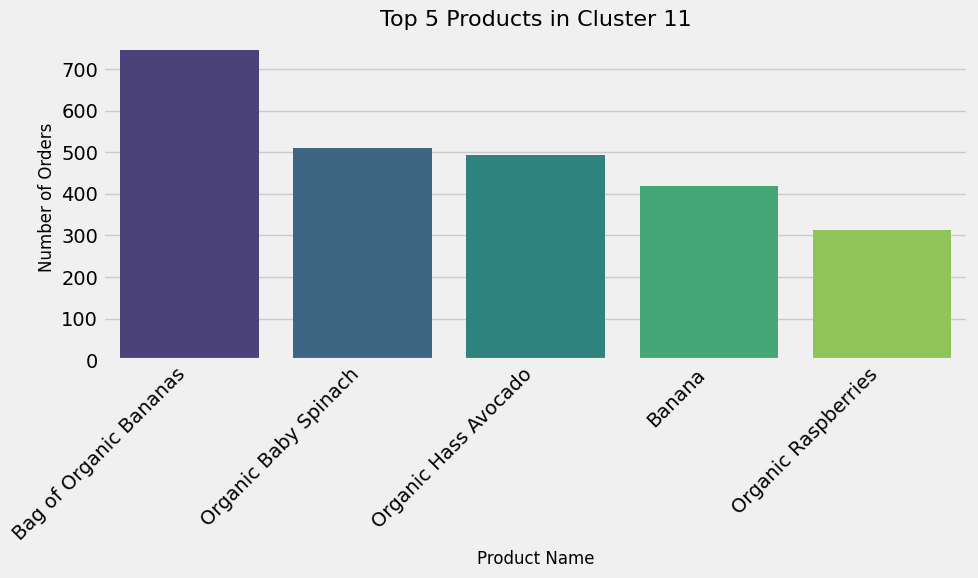

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


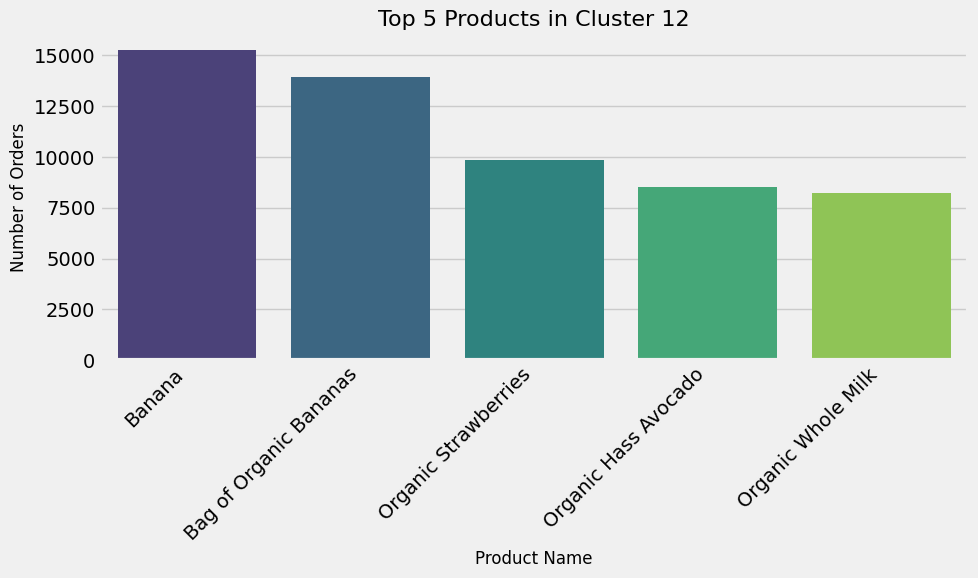

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


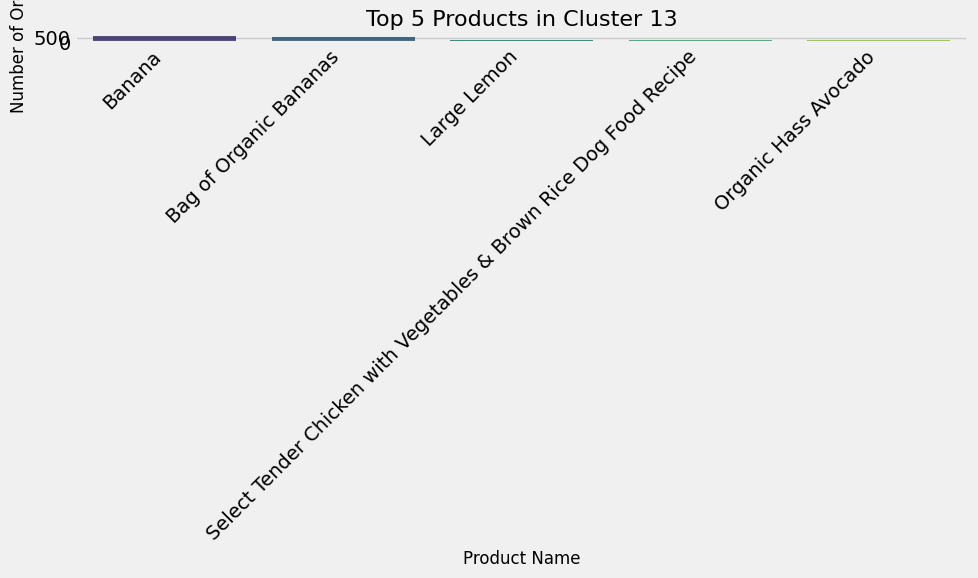

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


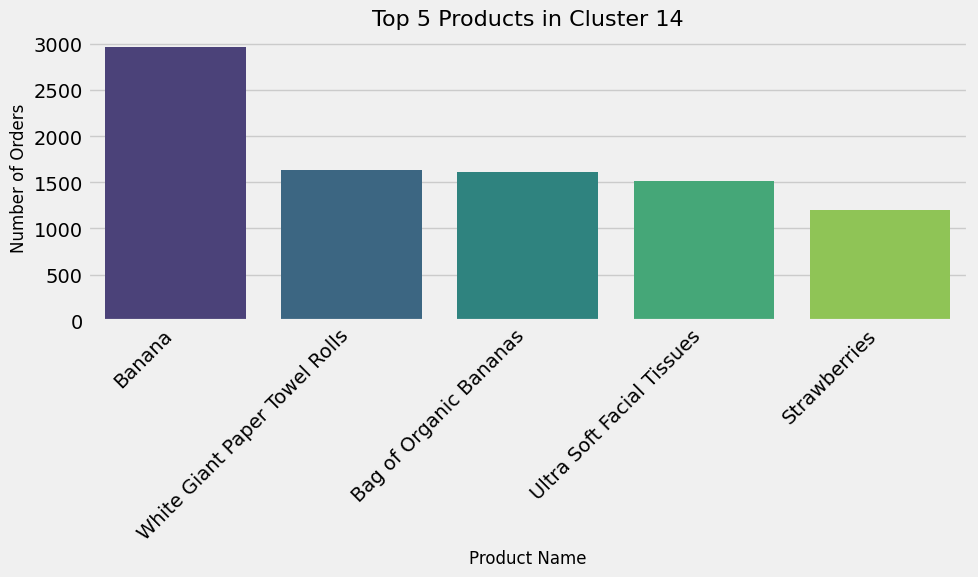

/tmp/ipykernel_101444/4115635993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


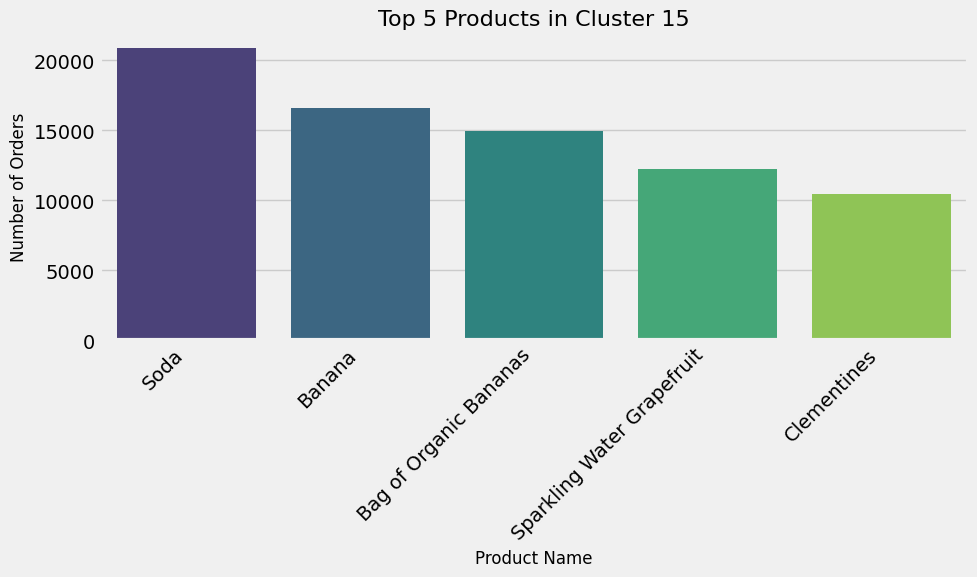

In [55]:
clusters = top_products_by_cluster['cluster'].unique()

plt.figure(figsize=(15, 8))

# Iterate through each cluster and create a bar plot for the top 5 products
for cluster in clusters:
    # Filter the data for the current cluster
    cluster_data = top_products_by_cluster[top_products_by_cluster['cluster'] == cluster]

    # Plot the top 5 products for the current cluster
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=cluster_data['product_name'],
        y=cluster_data['product_id'],
        palette='viridis'
    )

    plt.title(f"Top 5 Products in Cluster {cluster}", fontsize=16)
    plt.xlabel('Product Name', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

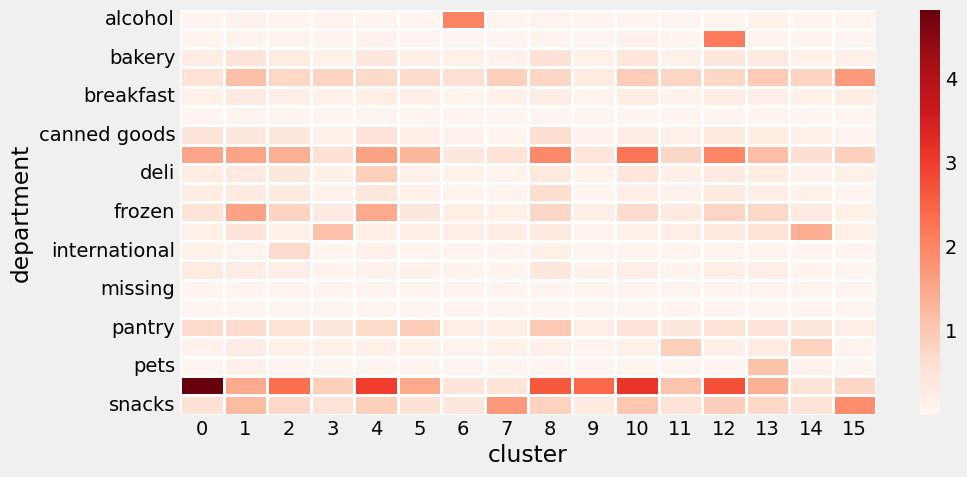

In [59]:
dep_vol_per_cluster = pd.DataFrame(all_orders_cluster.groupby(['cluster',"department"]).count())[["order_id"]].unstack(level=0).divide(orders_per_cluster.values, axis=1)
plt.figure(figsize=(10,5))
sns.heatmap(data=dep_vol_per_cluster, cmap="Reds", linewidths=1, xticklabels=range(0,16))
plt.xlabel("cluster")
plt.show()

In [60]:
# Calculate the total number of orders per cluster
orders_per_cluster = all_orders_cluster.groupby("cluster")["order_id"].nunique()

# Verify the number of clusters
num_clusters = len(orders_per_cluster)

# Check the length of the orders_per_cluster.values array
print("Length of orders_per_cluster.values array:", len(orders_per_cluster.values))

Length of orders_per_cluster.values array: 16


In [62]:
# Calculate the volume of orders per department per cluster
dep_vol_per_cluster = all_orders_cluster.groupby(['cluster', 'department']).size().unstack(level=0)

# Check if the number of clusters matches the expected length
if num_clusters == len(dep_vol_per_cluster.columns):
    # Divide the volume of orders per department by the total orders per cluster
    dep_vol_per_cluster = dep_vol_per_cluster.divide(orders_per_cluster.values, axis=1)
else:
    print("Number of clusters does not match the length of dep_vol_per_cluster.columns")

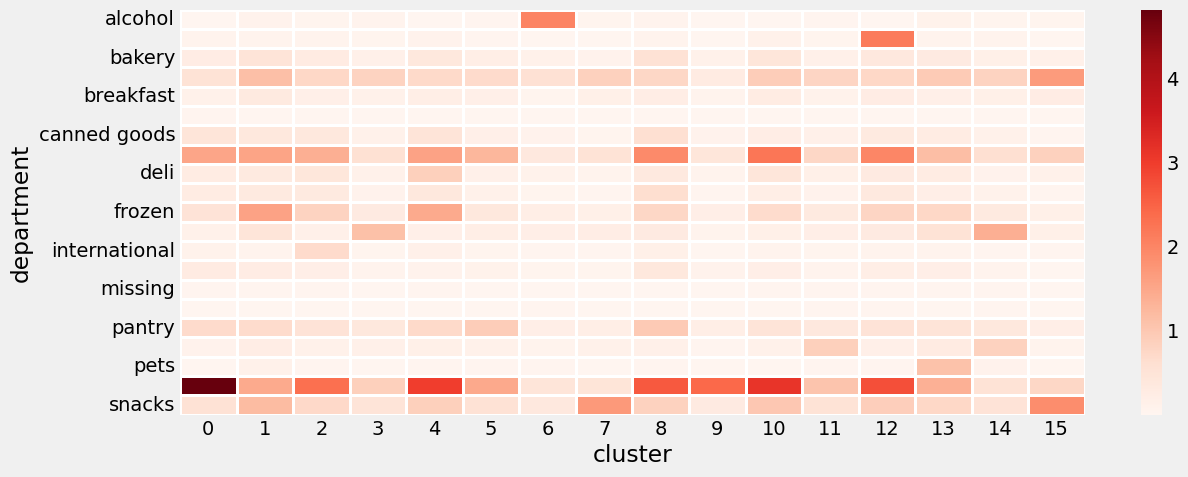

In [63]:
plt.figure(figsize=(13, 5))
sns.heatmap(data=dep_vol_per_cluster, cmap="Reds", linewidths=1, xticklabels=range(num_clusters))
plt.xlabel("cluster")
plt.show()

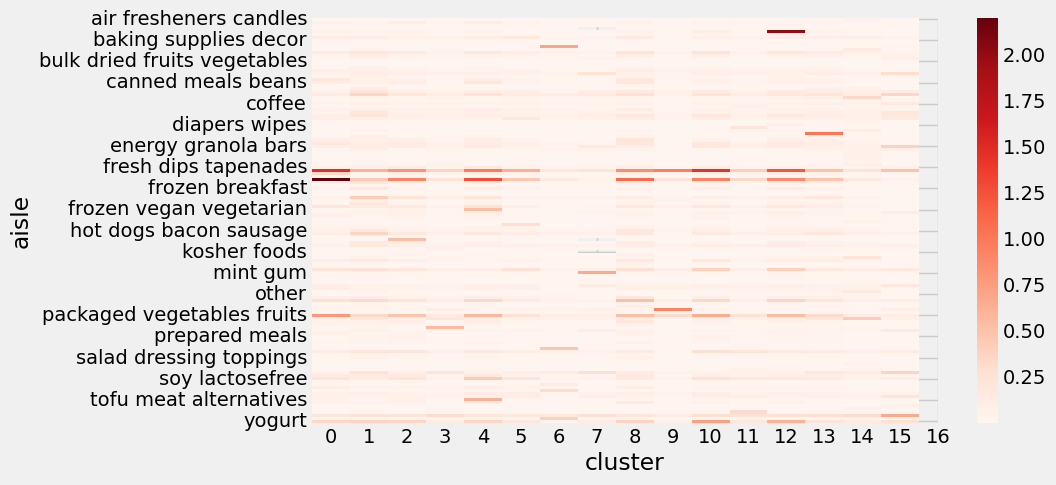

In [66]:
dep_pct_per_cluster = pd.DataFrame(all_orders_cluster.groupby(['cluster', 'department']).size().unstack(level=0))
aisle_vol_per_cluster = all_orders_cluster.groupby(["cluster", "aisle"]).count()["order_id"].unstack(level=0).divide(orders_per_cluster.values, axis=1)

plt.figure(figsize=(9,5))
sns.heatmap(data=aisle_vol_per_cluster, xticklabels=range(0,17), cmap="Reds")
plt.xlabel("cluster")
plt.show()